# RandomForest + RandomizedSearch 를 쓴 submission

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

data_dir = os.getenv('HOME') + '/aiffel/kaggle-kakr-housing-data/data'

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [2]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


# 전처리 시작

In [3]:
# Date 가 눈에 거슬린다. 전처리 ㄱㄱ
train['date'] = train['date'].apply(lambda i:i[:6]).astype(int)
test['date'] = test['date'].apply(lambda i:i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [4]:
# Price 도 처리해주기 (타겟데이터기 때문)

y = train['price']
del train['price']

print(train.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [5]:
del train['id']
del test['id']
print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [6]:
y

0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64

In [7]:
y = np.log1p(y)
y

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

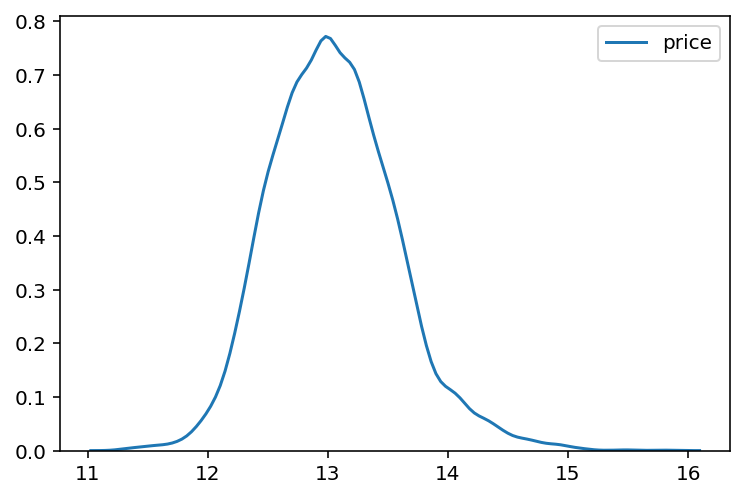

In [8]:
sns.kdeplot(y)
plt.show()

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [10]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

random_state = 1000

gboost = GradientBoostingRegressor(random_state = random_state)
xgboost = XGBRegressor(random_state = random_state)
lightgbm = LGBMRegressor(random_state = random_state)
rdforest = RandomForestRegressor(random_state = random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [11]:
def get_scores(models, train, y):
    df = {}
    
    for model in models:
        model_name = model.__class__.__name__
    
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state = random_state, test_size = 0.2)
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending = False)
        
    return score_df
    
get_scores(models, train, y)

,RMSE
RandomForestRegressor,136338.156764
GradientBoostingRegressor,136006.126298
LGBMRegressor,124587.617192
XGBRegressor,119718.058705


# RandomizedSearch 써보기

In [12]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num=10)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]

param_grid = {
    'n_estimators' : n_estimators,
    'max_depth' : max_depth,
}

model = RandomForestRegressor(random_state = random_state)

randomsearch_model = RandomizedSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)

randomsearch_model.fit(train, y)


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [13]:
randomsearch_model.cv_results_

{'mean_fit_time': array([4.600247  , 8.23092608, 7.62380786, 5.26315298, 8.80746322,
        0.561447  , 6.44278159, 1.72585487, 8.85373921, 6.7461205 ]),
 'std_fit_time': array([0.02910656, 0.18398801, 0.02041667, 0.01554168, 0.02364468,
        0.00191221, 0.0158282 , 0.00534453, 0.12434729, 0.33824091]),
 'mean_score_time': array([0.04248309, 0.06779423, 0.06436443, 0.04494133, 0.07405968,
        0.00531244, 0.05456834, 0.01543746, 0.07638092, 0.05769224]),
 'std_score_time': array([0.00548817, 0.00444803, 0.00130611, 0.0009785 , 0.00158979,
        0.00012111, 0.00121487, 0.00026937, 0.00540978, 0.00358369]),
 'param_n_estimators': masked_array(data=[73, 136, 136, 94, 157, 10, 115, 31, 157, 115],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_max_depth': masked_array(data=[60, 40, 60, 110, 30, 80, 40, 90, 60, 70],
              mask=[False, False, False, Fals

In [14]:
params = randomsearch_model.cv_results_['params']
params

[{'n_estimators': 73, 'max_depth': 60},
 {'n_estimators': 136, 'max_depth': 40},
 {'n_estimators': 136, 'max_depth': 60},
 {'n_estimators': 94, 'max_depth': 110},
 {'n_estimators': 157, 'max_depth': 30},
 {'n_estimators': 10, 'max_depth': 80},
 {'n_estimators': 115, 'max_depth': 40},
 {'n_estimators': 31, 'max_depth': 90},
 {'n_estimators': 157, 'max_depth': 60},
 {'n_estimators': 115, 'max_depth': 70}]

In [15]:
score = randomsearch_model.cv_results_['mean_test_score']
score

array([-0.03197269, -0.03167185, -0.03167185, -0.03188666, -0.03164212,
       -0.03557329, -0.03176111, -0.03264658, -0.03162603, -0.03176111])

In [16]:
results = pd.DataFrame(params)
results['score'] = score
results

,n_estimators,max_depth,score
0,73,60,-0.031973
1,136,40,-0.031672
2,136,60,-0.031672
3,94,110,-0.031887
4,157,30,-0.031642
5,10,80,-0.035573
6,115,40,-0.031761
7,31,90,-0.032647
8,157,60,-0.031626
9,115,70,-0.031761


In [17]:
results['RMSE'] = np.sqrt(-1*results['score'])
results = results.sort_values('RMSE')
results

,n_estimators,max_depth,score,RMSE
8,157,60,-0.031626,0.177837
4,157,30,-0.031642,0.177882
1,136,40,-0.031672,0.177966
2,136,60,-0.031672,0.177966
6,115,40,-0.031761,0.178216
9,115,70,-0.031761,0.178216
3,94,110,-0.031887,0.178568
0,73,60,-0.031973,0.178809
7,31,90,-0.032647,0.180684
5,10,80,-0.035573,0.188609


오랜 시간끝에, max_depth = 70 일때 n_estimators(나무의수) = 200 (그루) 일때 최적임을 알아냄

In [28]:
model = RandomForestRegressor(max_depth= 70, n_estimators = 200, random_state = random_state)

model.fit(train,y)
prediction = model.predict(test)
prediction

array([13.05073376, 13.1110929 , 14.03785504, ..., 13.05080684,
       12.70602274, 12.99765184])

In [29]:
prediction = np.expm1(prediction)
prediction

array([ 465436.80812098,  494395.40071016, 1249000.55922371, ...,
        465470.82110707,  329726.79756383,  441374.75494556])

In [30]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle-kakr-housing-data/data'

submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [31]:
submission['price'] = prediction
submission.head()

,id,price
0,15035,4.654368e+05
1,15036,4.943954e+05
2,15037,1.249001e+06
3,15038,2.980396e+05
4,15039,3.238417e+05


In [32]:
submission_csv_path = '{}/submission_{}.csv'.format(data_dir, 'Kyuhwan_Jung')
submission.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

/home/aiffel/aiffel/kaggle-kakr-housing-data/data/submission_Kyuhwan_Jung.csv


Populating the interactive namespace from numpy and matplotlib


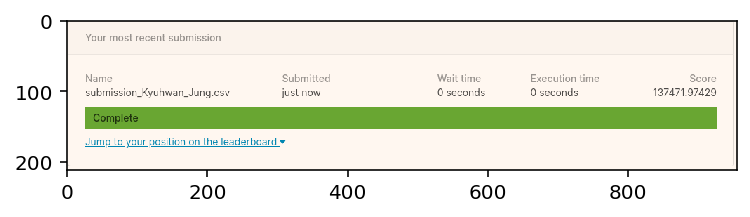

In [33]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread('kjkaggle1.png')
imgplot = plt.imshow(img)
plt.show()

# 137000 정도 나왔습니다 2차땐 117000